In [456]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [457]:
filename = '../data/processed_data.sav'
data = pickle.load(open(filename, 'rb'))

### Limit model to only include 11th game in season or later

In [458]:
data_model = data[(data['home_game_season'] > 10) & (data['away_game_season'] > 10)].copy()

### Seperate X and y values

In [459]:
columns = list(data.columns.values)

In [460]:
not_in_X = ['date_game', 'season', 'home_team', 'away_team', 'home_game_season', 
            'home_pts', 'away_game_season', 'away_date_game', 'away_pts', 'score_margin']
X_columns = [column for column in columns if column not in not_in_X]

### Train test split

In [461]:
X = data_model[X_columns].copy()
y = data_model['score_margin'].copy()

In [462]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

In [463]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

### Initial Model Comparison

In [464]:
alphas = 10**np.linspace(-2,4,50)

lin_reg = LinearRegression()
ridge_reg = RidgeCV(alphas=alphas, cv=5)
lasso_reg = LassoCV(alphas=alphas, cv=5, tol=0.01)
elast_net = ElasticNetCV(alphas=alphas, cv=5)

In [465]:
model_list = [
    ('lin_reg', lin_reg),
    ('ridge_reg', ridge_reg),
    ('lasso_reg', lasso_reg),
    ('elast_net', elast_net)
]

sorted_margin = sorted([(name, cross_val_score(model, X_train, y_train, cv=5).mean()) for name, 
                         model in model_list], key=lambda x: x[1], reverse= True)

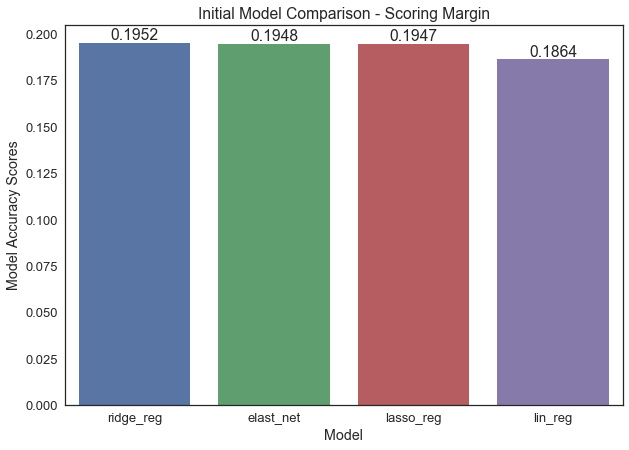

In [466]:
newx, newy = zip(*sorted_margin)

sns.set(style="white", font_scale=1.3)

fig, ax = plt.subplots(figsize=(10,7))
ax = sns.barplot(x=newx, y=newy)
plt.title('Initial Model Comparison - Scoring Margin')
plt.ylabel('Model Accuracy Scores')
plt.xlabel('Model')

rects = ax.patches

for rect, newy in zip(rects, newy):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            round(newy,4), ha='center', va='bottom')

#fig.savefig('initial_model_comparison.png', transparent = False, dpi = 80, bbox_inches = 'tight')

### Examine feature correlation

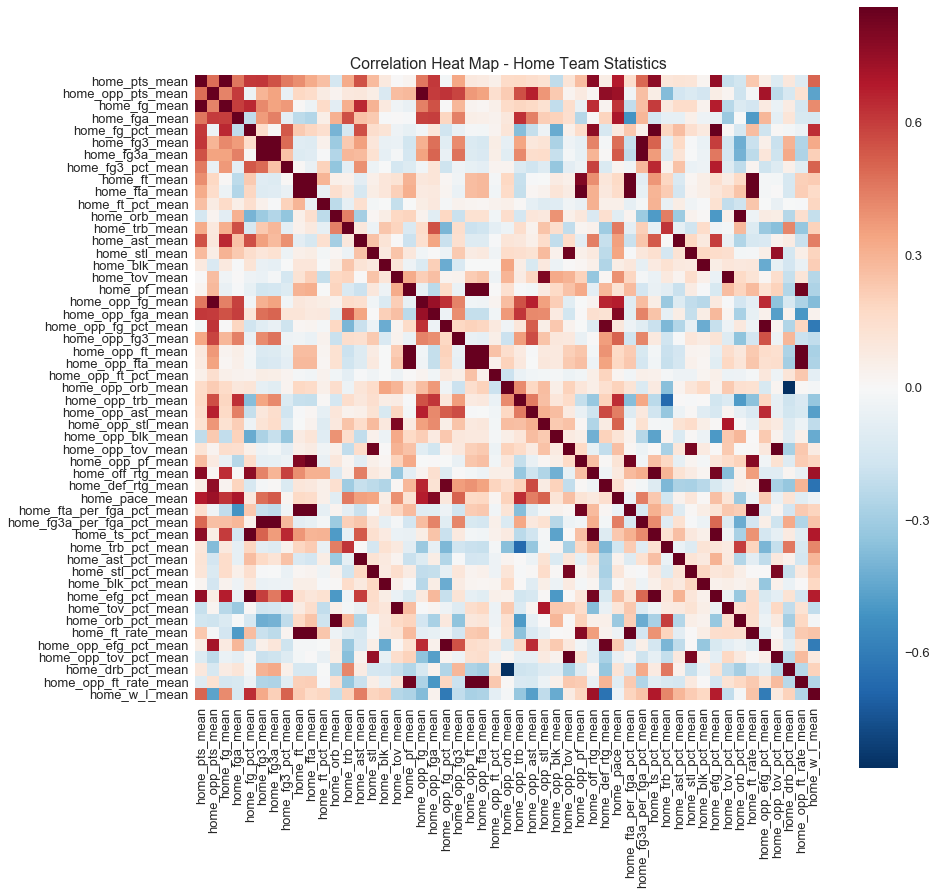

In [467]:
X_home = X.iloc[:,:51]

corr = X_home.corr()

fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(corr, vmax=.8, square=True)
plt.title('Correlation Heat Map - Home Team Statistics')

#fig.savefig('home_team_correlations.png', transparent = False, dpi = 80, bbox_inches = 'tight')

### Explore PCA Regression

In [468]:
pca = PCA()
pc_X_train = pca.fit_transform(X_train)

In [469]:
MSE = []
pcr = LinearRegression()

#First CV is completed for just the intercept (no principal components)
MSE.append(np.mean(-1 * cross_val_score(pcr,
                                        np.ones((len(pc_X_train), 1)),
                                        y_train,
                                        cv=8,
                                        scoring='neg_mean_squared_error')))

#Remaining CVs for all principal omponents
for i in range(1, pc_X_train.shape[1]):
    MSE_temp = -1 * cross_val_score(pcr,
                                    pc_X_train[:, :i],
                                    y_train,
                                    cv=8,
                                    scoring='neg_mean_squared_error')
    
    MSE_temp = np.mean(MSE_temp)
    MSE.append(MSE_temp)

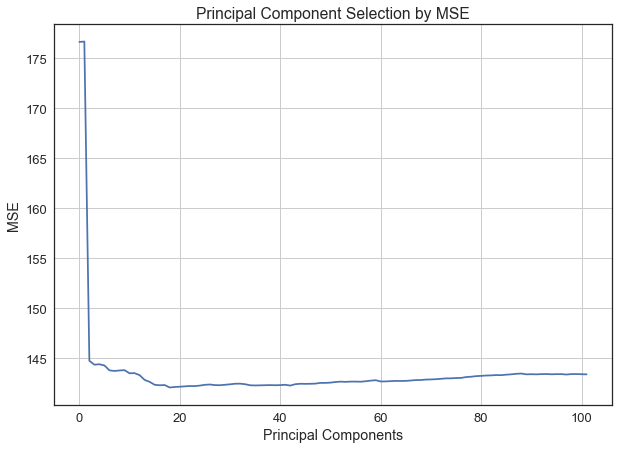

In [470]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(MSE)
plt.grid()
ax.set_ylabel('MSE')
ax.set_xlabel('Principal Components')
ax.set_title('Principal Component Selection by MSE')

#fig.savefig('PCR.png', transparent = False, dpi = 80, bbox_inches = 'tight')

In [471]:
np.mean(cross_val_score(pcr, pc_X_train[:, 0:18], y_train, cv=8))

0.1939838959975001

### Dimensionality Reduction 

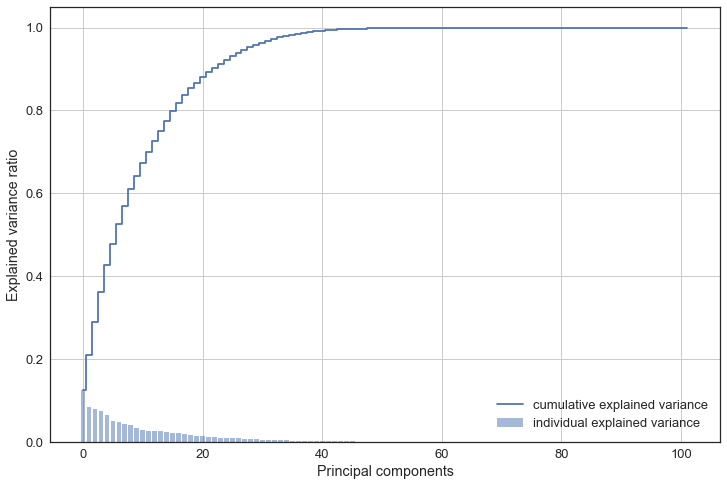

In [472]:
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(range(102), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(102), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.grid()
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

#fig.savefig('explained_variance.png', transparent = False, dpi = 80, bbox_inches = 'tight')

In [473]:
np.cumsum(pca.explained_variance_ratio_[:29])

array([ 0.12491695,  0.20891864,  0.28830818,  0.36207644,  0.427046  ,
        0.47795325,  0.52664579,  0.56888689,  0.6096265 ,  0.6425455 ,
        0.67217536,  0.69898536,  0.72540987,  0.75095232,  0.77558664,
        0.79776675,  0.81895898,  0.83720366,  0.85338434,  0.86744746,
        0.88102555,  0.89183117,  0.90240768,  0.9121941 ,  0.92164584,
        0.93066658,  0.9392958 ,  0.9470381 ,  0.95308611])

### Feature Engineering - Attempt to account for team streaks

In [474]:
corr = data_model.corr()

In [475]:
margin_features = list(corr[(corr['score_margin']>=0.25)].index)
margin_corr = corr['score_margin'][margin_features]

In [476]:
margin_corr

home_pts             0.554401
home_off_rtg_mean    0.260034
home_w_l_mean        0.314468
score_margin         1.000000
Name: score_margin, dtype: float64

### Import New Dataset with Additional Features

In [477]:
filename = '../data/new_features.sav'
new_data = pickle.load(open(filename, 'rb'))

In [478]:
new_data_model = new_data[(new_data['home_game_season'] > 10) & (new_data['away_game_season'] > 10)].copy()

In [479]:
new_columns = list(new_data.columns.values)
not_in_X = ['date_game', 'season', 'home_team', 'away_team', 'home_game_season', 
            'home_pts', 'away_game_season', 'away_date_game', 'away_pts', 'score_margin',
            'away_off_rtg_mean_last5', 'away_w_l_mean_last5', 'home_lat_long', 'away_lat_long']
new_X_columns = [column for column in new_columns if column not in not_in_X]

### Train test split

In [480]:
X_new = new_data_model[new_X_columns].copy()
y_new = new_data_model['score_margin'].copy()

In [481]:
std_scaler = StandardScaler()
X_new_scaled = std_scaler.fit_transform(X_new)

In [482]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new_scaled, y_new, test_size=0.3, random_state=0)

### Model improvement evaluation

In [483]:
alphas = 10**np.linspace(-2,4,50)

ridge_reg = RidgeCV(alphas=alphas, cv=5)

In [484]:
sorted_margin = sorted([('Original Model', cross_val_score(ridge_reg, X_train, y_train, cv=5).mean()),
                        ('New Model', cross_val_score(ridge_reg, X_new_train, y_new_train, cv=5).mean())],
                        key=lambda x: x[1], reverse= True)

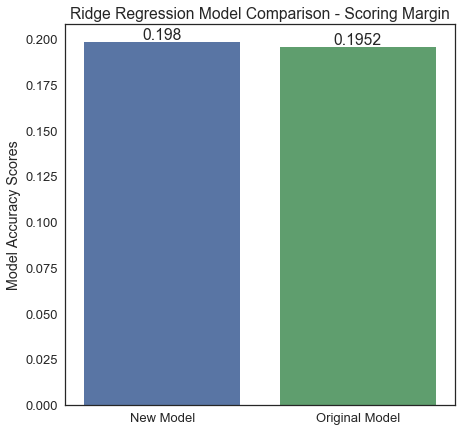

In [485]:
newx, newy = zip(*sorted_margin)

sns.set(style="white", font_scale=1.3)

fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(x=newx, y=newy)
plt.title('Ridge Regression Model Comparison - Scoring Margin')
plt.ylabel('Model Accuracy Scores')

rects = ax.patches

for rect, newy in zip(rects, newy):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            round(newy,4), ha='center', va='bottom')

#fig.savefig('new_model_comparison.png', transparent = False, dpi = 80, bbox_inches = 'tight')

### Finalize Model

In [486]:
alphas = 10**np.linspace(-2,4,50)
model = RidgeCV(alphas=alphas, cv=8)
model.fit(X_new_train, y_new_train)

RidgeCV(alphas=array([  1.00000e-02,   1.32571e-02,   1.75751e-02,   2.32995e-02,
         3.08884e-02,   4.09492e-02,   5.42868e-02,   7.19686e-02,
         9.54095e-02,   1.26486e-01,   1.67683e-01,   2.22300e-01,
         2.94705e-01,   3.90694e-01,   5.17947e-01,   6.86649e-01,
         9.10298e-01,   1...     2.44205e+03,   3.23746e+03,   4.29193e+03,   5.68987e+03,
         7.54312e+03,   1.00000e+04]),
    cv=8, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [487]:
pred = model.predict(X_new_test)

In [488]:
model.score(X_new_test, y_new_test)

0.17655652714345171

In [489]:
mean_squared_error(y_new_test, pred)

148.53460279962658

In [490]:
model.alpha_

1842.0699693267163

### Residuals plot

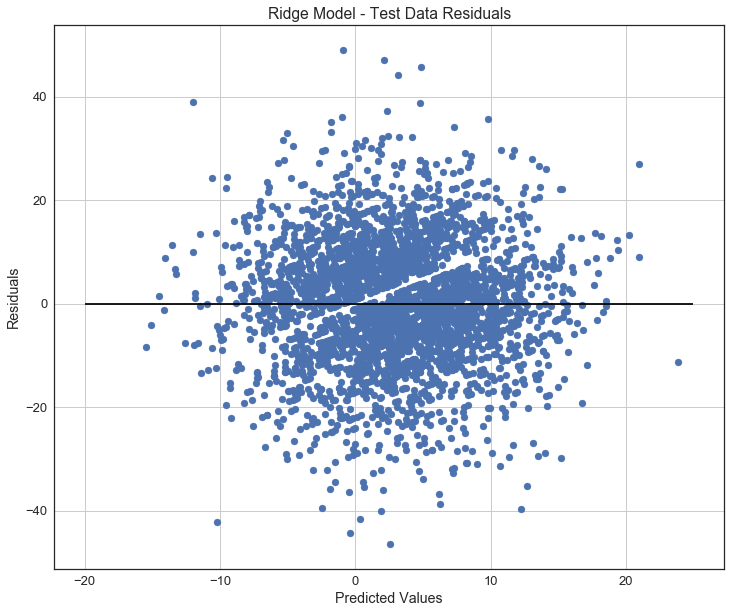

In [491]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(pred, pred-y_new_test, label="Test Data")
ax.hlines(y=0, xmin=-20, xmax=25)
ax.set_ylabel('Residuals')
ax.set_xlabel('Predicted Values')
ax.set_title('Ridge Model - Test Data Residuals')
plt.grid()
#fig.savefig('residuals.png', transparent = False, dpi = 80, bbox_inches = 'tight')

### Explore coefficient weights

In [492]:
weights = dict(zip(list(X_new.columns), list(abs(model.coef_))))

In [493]:
sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)

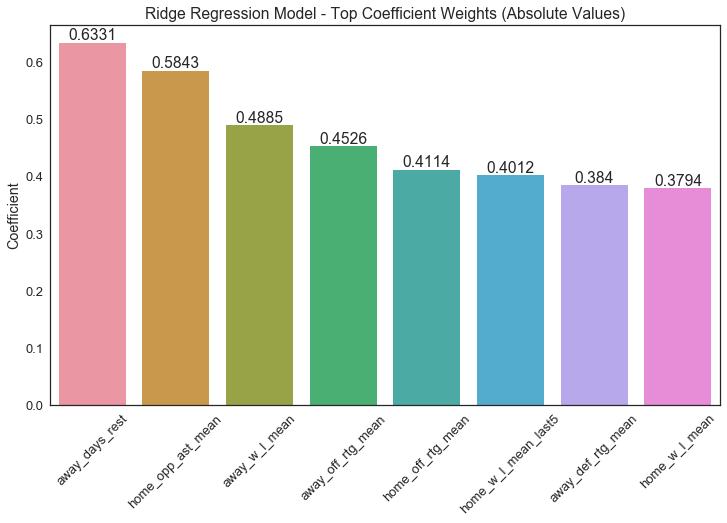

In [494]:
newx, newy = zip(*sorted_weights)
newx, newy = newx[:8], newy[:8]

sns.set(style="white", font_scale=1.3)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.barplot(x=newx, y=newy)
plt.title('Ridge Regression Model - Top Coefficient Weights (Absolute Values)')
plt.ylabel('Coefficient Weight')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)

rects = ax.patches

for rect, newy in zip(rects, newy):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            round(newy,4), ha='center', va='bottom')

#fig.savefig('model_coefficients.png', transparent = False, dpi = 80, bbox_inches = 'tight')